# Rainfall - Runoff ML base model
 - 강우 - 유입량 관계를 예측하는 머신러닝 base code를 제공
 - 분석환경 : 구글 colab

## Step1. 파일 읽기

In [ ]:
# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import datetime

In [ ]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

In [ ]:
# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df = pd.read_csv(path + 'soyang.csv')
df

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [ ]:
# 날짜 데이터 타입 변환
df['Date'] = df['OBSYMD'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d')) 
df

,OBSYMD,DAMCD,RF,IQTY,Date
0,19740101,1012110,0.0000,10.000,1974-01-01
1,19740102,1012110,0.0000,9.000,1974-01-02
2,19740103,1012110,0.0000,4.800,1974-01-03
3,19740104,1012110,0.0000,6.100,1974-01-04
4,19740105,1012110,0.0000,5.800,1974-01-05
...,...,...,...,...,...
15985,20171007,1012110,0.1613,6.583,2017-10-07
15986,20171008,1012110,0.0000,26.463,2017-10-08
15987,20171009,1012110,0.0000,6.836,2017-10-09
15988,20171010,1012110,1.9319,19.367,2017-10-10


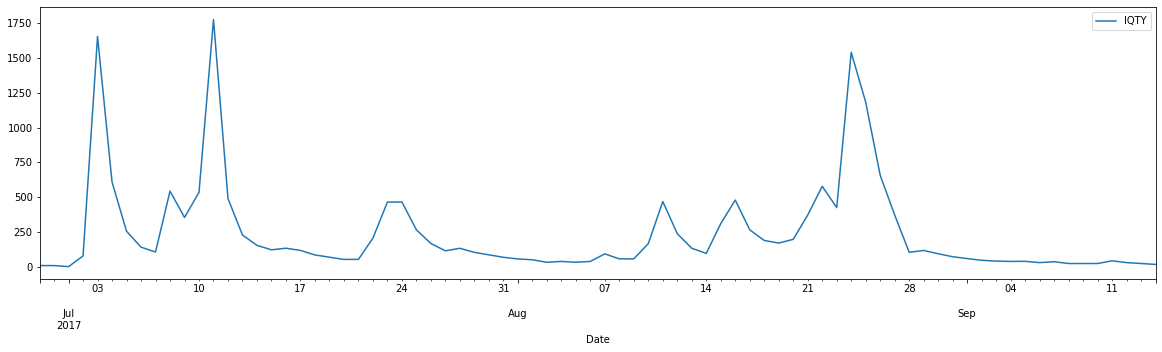

In [ ]:
# 2017년 7~9월 유입량 패턴 확인, 유입량 상승기가 2~3일 패턴 밖에 되지 않음을 확인
df[(df['OBSYMD'] > 20170628) & (df['OBSYMD'] < 20170915)][['Date', 'IQTY']].set_index('Date').plot(figsize = (20,5))

## Step 2. 데이터 전처리

In [ ]:
# 시계열에 대한 Lag변수를 만들기 위한 함수
def buildLaggedFeatures(s,lag=2,dropna=True):

# Builds a new DataFrame to facilitate regressing over all possible lagged features
  if type(s) is pd.DataFrame:
    new_dict={}
    for col_name in s:
        new_dict[col_name]=s[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=s.index)

  elif type(s) is pd.Series:
    the_range=range(lag+1)
    res=pd.concat([s.shift(i) for i in the_range],axis=1)
    res.columns=['lag_%d' %i for i in the_range]
  else:
    print('Only works for DataFrame or Series')
    return None
  if dropna:
    return res.dropna()
  else:
    return res 

In [ ]:
# 강우에 대한 30일간의 Lag변수 생성
rf_30 = buildLaggedFeatures(df[['RF']],30)
rf_30

,RF,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,...,RF_lag21,RF_lag22,RF_lag23,RF_lag24,RF_lag25,RF_lag26,RF_lag27,RF_lag28,RF_lag29,RF_lag30
30,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
31,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
32,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
34,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,...,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,0.0000
15986,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,...,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000
15987,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,...,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000
15988,1.9319,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,...,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000


In [ ]:
# 유입량에 대한 30일간의 Lag변수 생성

q_30 = buildLaggedFeatures(df[['IQTY']],30)
q_30

,IQTY,IQTY_lag1,IQTY_lag2,IQTY_lag3,IQTY_lag4,IQTY_lag5,IQTY_lag6,IQTY_lag7,IQTY_lag8,IQTY_lag9,...,IQTY_lag21,IQTY_lag22,IQTY_lag23,IQTY_lag24,IQTY_lag25,IQTY_lag26,IQTY_lag27,IQTY_lag28,IQTY_lag29,IQTY_lag30
30,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,7.800,...,3.500,6.200,6.800,9.400,8.700,5.800,6.100,4.800,9.000,10.000
31,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,10.400,...,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100,4.800,9.000
32,3.800,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,7.100,...,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100,4.800
33,6.300,3.800,6.300,6.400,6.500,6.400,4.000,4.000,3.800,5.500,...,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800,6.100
34,6.900,6.300,3.800,6.300,6.400,6.500,6.400,4.000,4.000,3.800,...,6.400,6.500,4.500,5.100,3.500,6.200,6.800,9.400,8.700,5.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,18.348,5.497,...,19.126,20.070,20.093,26.512,32.982,46.066,26.515,26.489,26.468,39.481
15986,26.463,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,18.348,...,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515,26.489,26.468
15987,6.836,26.463,6.583,12.864,6.318,12.607,12.635,12.489,12.357,11.919,...,12.765,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515,26.489
15988,19.367,6.836,26.463,6.583,12.864,6.318,12.607,12.635,12.489,12.357,...,25.619,12.765,19.093,19.126,20.070,20.093,26.512,32.982,46.066,26.515


In [ ]:
# 30일간의 lag된 강우와, 30일째 유입량을 변수로 만듬
# RF(t) ~ RF(t-30)으로  Q(t)를 예측하는 문제로 설정함
data = pd.concat([rf_30, q_30['IQTY']], axis=1)
data = data.reset_index(drop=True)
data

,RF,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,...,RF_lag22,RF_lag23,RF_lag24,RF_lag25,RF_lag26,RF_lag27,RF_lag28,RF_lag29,RF_lag30,IQTY
0,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.400
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.300
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.800
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.300
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15955,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,...,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,0.0000,6.583
15956,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,26.463
15957,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,...,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,6.836
15958,1.9319,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,...,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,19.367


In [ ]:
data1 = data[['RF', 'IQTY']]
data1

,RF,IQTY
0,0.0000,6.400
1,0.0000,6.300
2,0.0000,3.800
3,0.0000,6.300
4,0.0000,6.900
...,...,...
15955,0.1613,6.583
15956,0.0000,26.463
15957,0.0000,6.836
15958,1.9319,19.367


In [ ]:
# train dataset과 test dataset으로 분리
train = data[:15000]
test = data[15000:]

In [ ]:
# train dataset과 test dataset으로 분리
train = data1[:15000]
test = data1[15000:]

In [ ]:
# 사용할 머신러닝 알고리즘 import

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR

from sklearn.metrics import r2_score


In [ ]:
# 독립변수와 종속변수 분리

X_train = train.drop(['IQTY'], axis = 1)
y_train = train['IQTY']
X_test = test[X_train.columns]
y_test = test['IQTY']

In [ ]:
y_train

0         6.400
1         6.300
2         3.800
3         6.300
4         6.900
          ...  
14995     2.874
14996     6.514
14997    10.482
14998     3.533
14999     3.907
Name: IQTY, Length: 15000, dtype: float64

# Step 3. 머신러닝 훈련 및 예측

In [ ]:
# 선형회귀에 대한 예측

m = LinearRegression()
m.fit(X_train,y_train)
pred=m.predict(X_test)
r2=r2_score(y_test.to_numpy(), pred)
r2

0.4176480418583133

In [ ]:
# 선형회귀, Lasso, Ridge, SVR, Randomforest, LGBM 모델을 설정하고, 위와 동일하게 반복 수행하며
# test dataset에 대한 r-squared 계산

models=[LinearRegression(), 
        Lasso(random_state=0), 
        Ridge(random_state=0),
        SVR(kernel='poly', degree = 2), 
        RandomForestRegressor(random_state=0), 
        LGBMRegressor(random_state=0)]
     
model_names=['LinearRegression',
             'Lasso', 
             'Ridge',
             'SVR_poly',
             'RandomForestRegressor',
             'LGBMRegressor']

r2_list=[]

for model in range (len(models)):
  print(model_names[model])
  clf=models[model]
  clf.fit(X_train,y_train)
  pred=clf.predict(X_test)
  r2=r2_score(y_test.to_numpy(), pred)
  print(r2)
  r2_list.append(r2)
  

LinearRegression
0.4176480418583133
Lasso
0.41771875740242836
Ridge
0.41764810022193377
SVR_poly
0.5445572016871514
RandomForestRegressor
0.339609881397147
LGBMRegressor
0.5078705695269825


In [ ]:
print(r2_list)

[0.6884932592899007, 0.6887537266432107, 0.6884933422589641, 0.8029670669184789, 0.8615841731372769, 0.8268635759935792]


## Step4. LSTM 모형 훈련 및 예측

In [ ]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)


1.15.2


In [ ]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

In [ ]:
# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df = pd.read_csv(path + 'soyang.csv')
df

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['OBSYMD', 'DAMCD']).copy()
df_in

,RF,IQTY
0,0.0000,10.000
1,0.0000,9.000
2,0.0000,4.800
3,0.0000,6.100
4,0.0000,5.800
...,...,...
15985,0.1613,6.583
15986,0.0000,26.463
15987,0.0000,6.836
15988,1.9319,19.367


In [ ]:
# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

df_in_scaled


,RF,IQTY
0,0.000000,0.001350
1,0.000000,0.001215
2,0.000000,0.000648
3,0.000000,0.000824
4,0.000000,0.000783
...,...,...
15985,0.000600,0.000889
15986,0.000000,0.003573
15987,0.000000,0.000923
15988,0.007190,0.002615


In [ ]:
# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'IQTY'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(15960, 30, 2)
[[[0.         0.00135033]
  [0.         0.0012153 ]
  [0.         0.00064816]
  ...
  [0.         0.00054013]
  [0.         0.00086421]
  [0.         0.00087771]]

 [[0.         0.0012153 ]
  [0.         0.00064816]
  [0.         0.0008237 ]
  ...
  [0.         0.00086421]
  [0.         0.00087771]
  [0.         0.00086421]]

 [[0.         0.00064816]
  [0.         0.0008237 ]
  [0.         0.00078319]
  ...
  [0.         0.00087771]
  [0.         0.00086421]
  [0.         0.00085071]]

 ...

 [[0.         0.00357689]
  [0.         0.0035804 ]
  [0.05416152 0.00622043]
  ...
  [0.01041496 0.00173706]
  [0.0006003  0.00088892]
  [0.         0.00357338]]

 [[0.         0.0035804 ]
  [0.05416152 0.00622043]
  [0.         0.00445366]
  ...
  [0.0006003  0.00088892]
  [0.         0.00357338]
  [0.         0.00092309]]

 [[0.05416152 0.00622043]
  [0.         0.00445366]
  [0.00024377 0.00357999]
  ...
  [0.         0.00357338]
  [0.         0.00092309]
  [0.0071898  0.0026151

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [ ]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

drop_out_rate = 0.05

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(8, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs) 
  x2 = LSTM(8, recurrent_dropout=drop_out_rate)(x1) 
  x3 = Dropout(drop_out_rate)(x2) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 4s 397us/step - loss: 54929.9712 - mae: 67.3506 - val_loss: 58919.4757 - val_mae: 71.5014
Epoch 2/1000
10000/10000 [==============================] - 2s 224us/step - loss: 54629.2678 - mae: 65.3058 - val_loss: 58694.0022 - val_mae: 70.2416
Epoch 3/1000
10000/10000 [==============================] - 2s 231us/step - loss: 54456.8777 - mae: 64.2165 - val_loss: 58540.4379 - val_mae: 69.4638
Epoch 4/1000
10000/10000 [==============================] - 2s 230us/step - loss: 54337.4613 - mae: 63.5006 - val_loss: 58424.6099 - val_mae: 68.9210
Epoch 5/1000
10000/10000 [==============================] - 2s 230us/step - loss: 54235.6928 - mae: 62.9407 - val_loss: 58317.1167 - val_mae: 68.4639
Epoch 6/1000
10000/10000 [==============================] - 2s 232us/step - loss: 54138.1133 - mae: 62.4704 - val_loss:

In [ ]:
y_pred = model_base.predict(X_test)
y_obs = y_test

In [ ]:
df_pred = pd.DataFrame({'Date' : df['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,17.418,12.799973,0.7594
1,2015-02-26,10.618,16.595860,0.8506
2,2015-02-27,7.182,17.496658,0.0000
3,2015-02-28,7.132,14.991547,0.0000
4,2015-03-01,4.029,13.654091,0.0000
...,...,...,...,...
955,2017-10-07,6.583,20.072886,0.1613
956,2017-10-08,26.463,17.557571,0.0000
957,2017-10-09,6.836,18.372564,0.0000
958,2017-10-10,19.367,16.524826,1.9319


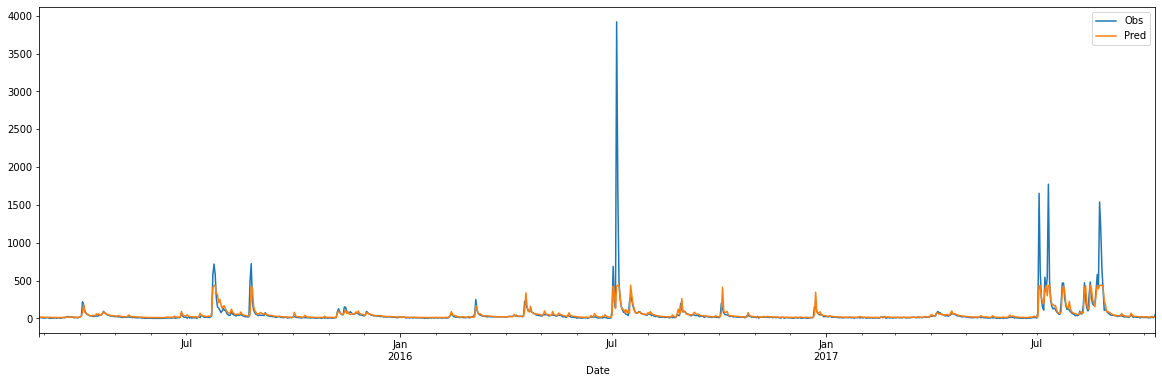

In [ ]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

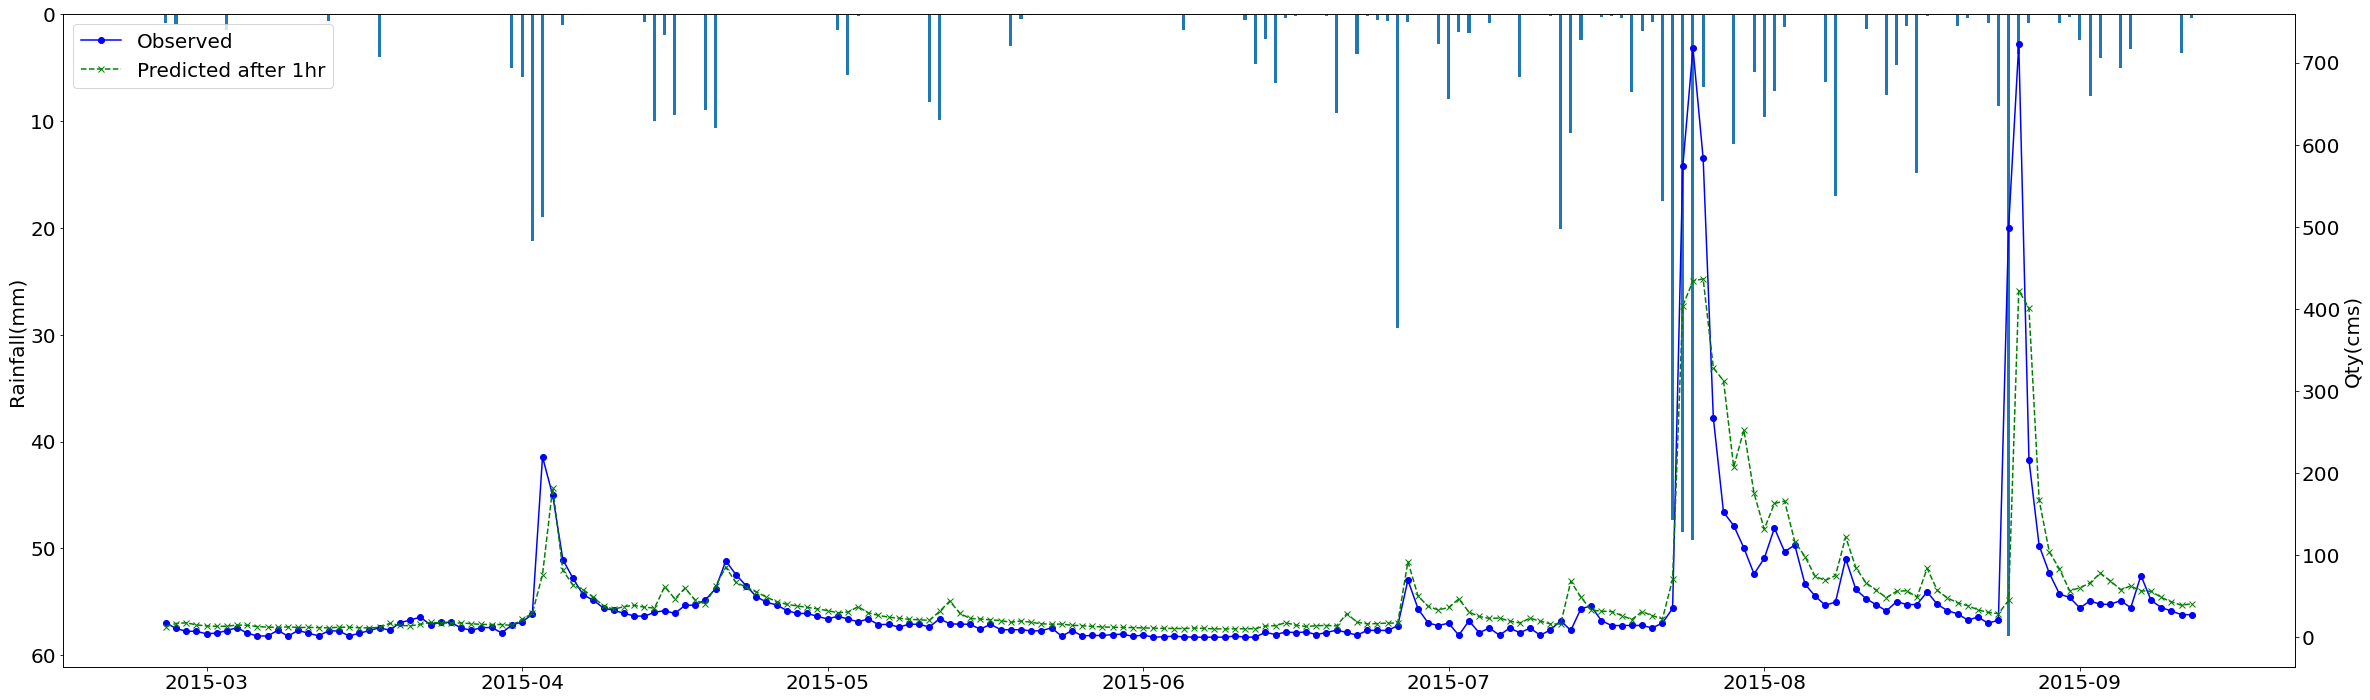

In [ ]:
df_predict = df_pred[0:200].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

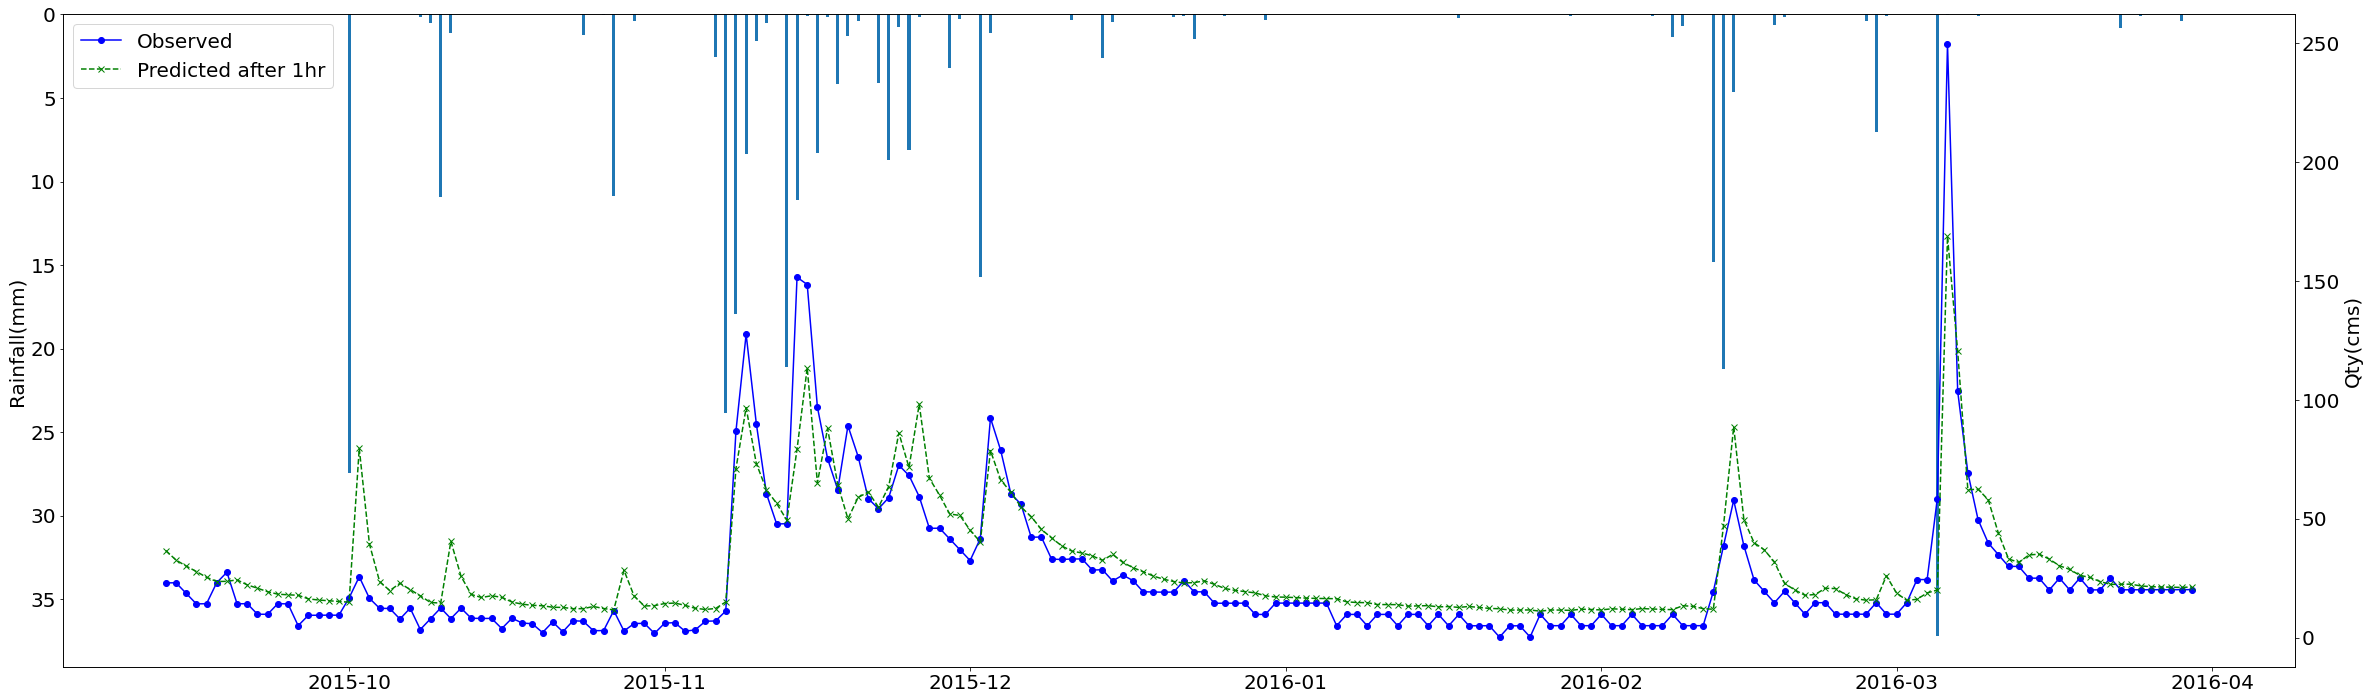

In [ ]:
df_predict = df_pred[200:400].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

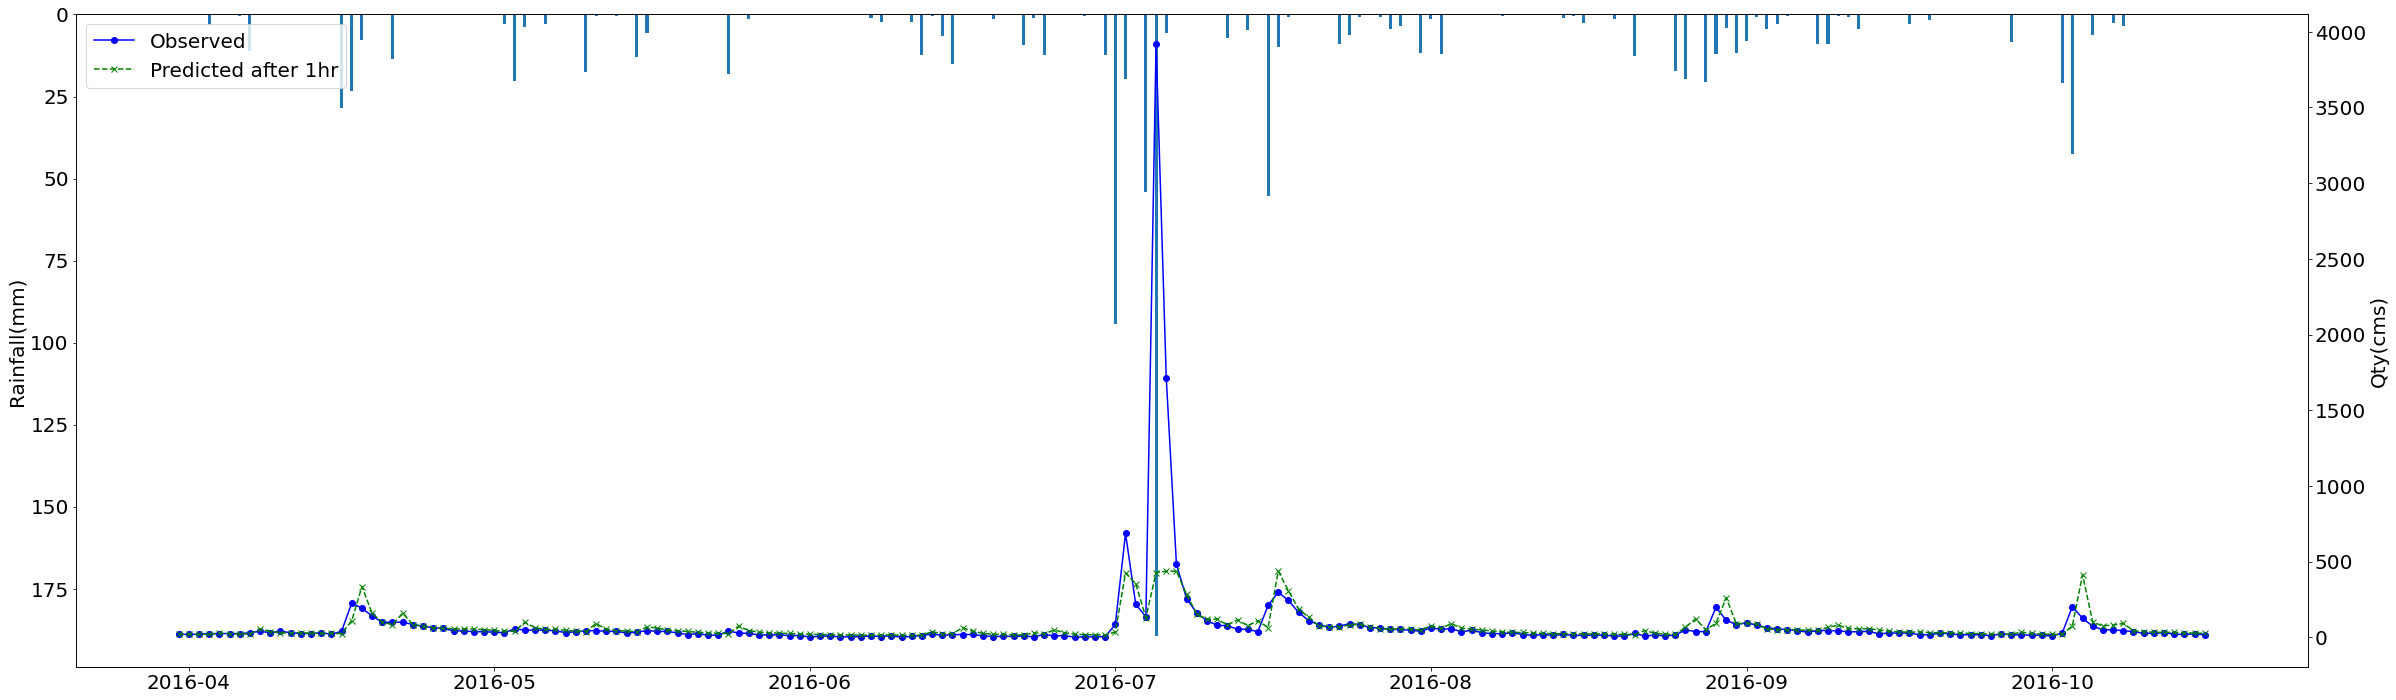

In [ ]:
df_predict = df_pred[400:600].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

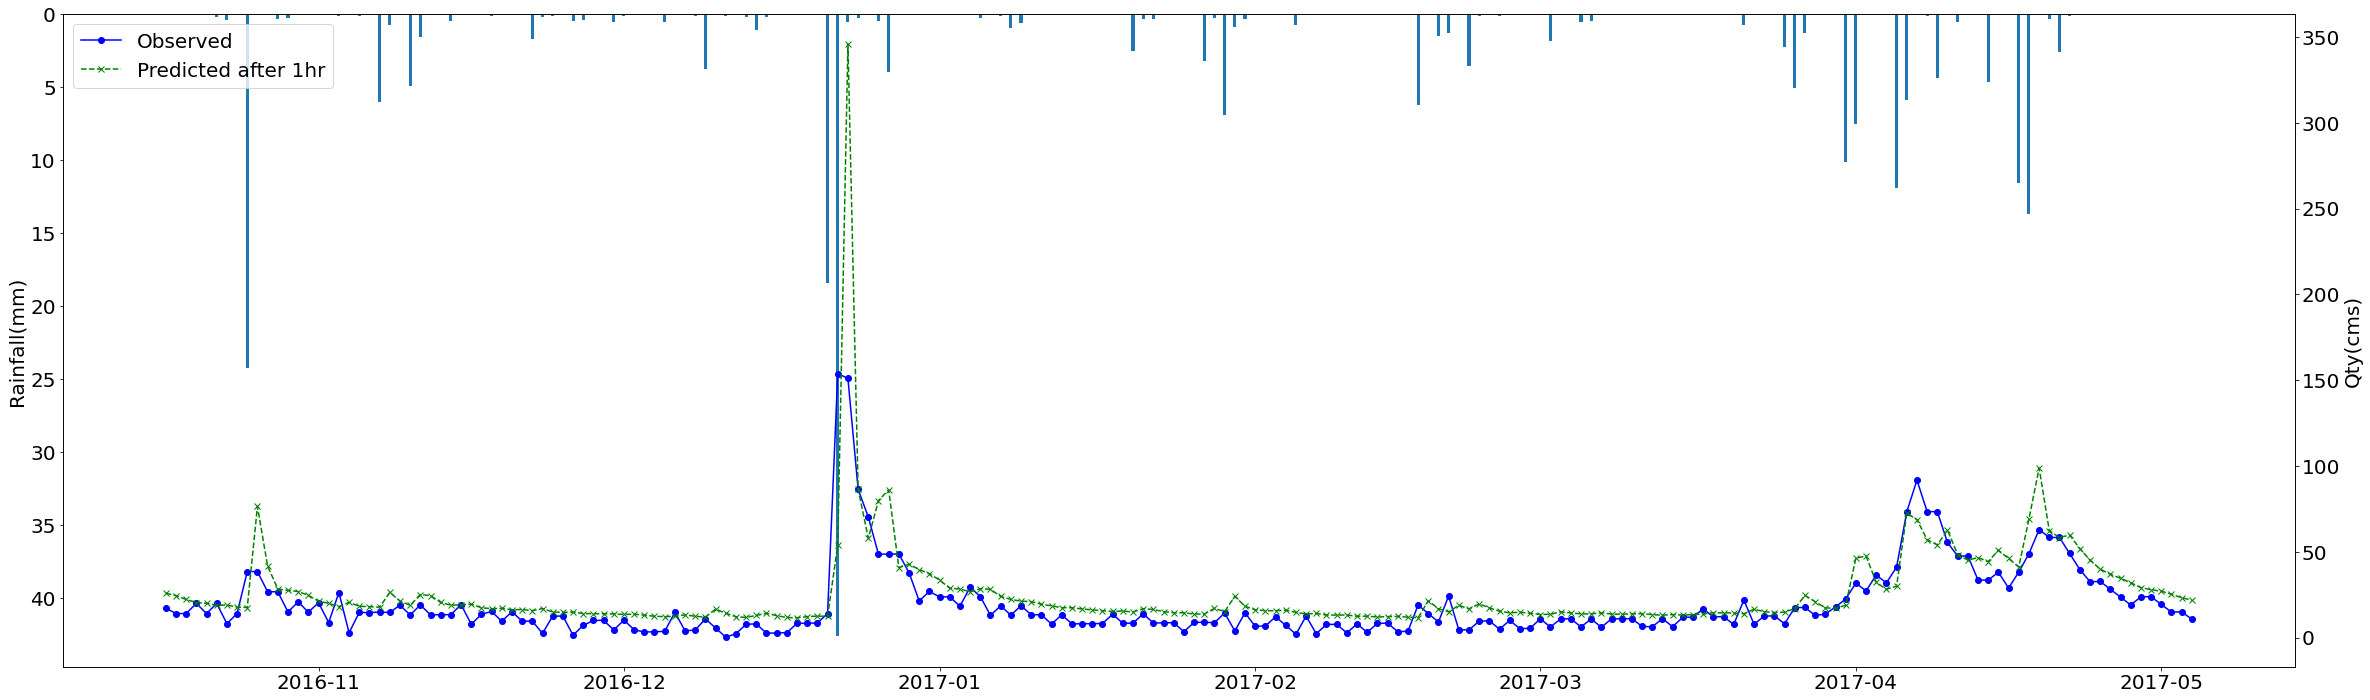

In [ ]:
df_predict = df_pred[600:800].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

## Step5. TCN(Temporal Convolutional Neural Network)

In [ ]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 4.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2


In [ ]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df = pd.read_csv(path + 'soyang.csv')

# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df.drop(columns = ['OBSYMD', 'DAMCD']).copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

df_in_scaled


,RF,IQTY
0,0.000000,0.001350
1,0.000000,0.001215
2,0.000000,0.000648
3,0.000000,0.000824
4,0.000000,0.000783
...,...,...
15985,0.000600,0.000889
15986,0.000000,0.003573
15987,0.000000,0.000923
15988,0.007190,0.002615


In [ ]:
# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'IQTY'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
print(dataset_y_reshaped)

(15960, 30, 2)
[[[0.         0.00135033]
  [0.         0.0012153 ]
  [0.         0.00064816]
  ...
  [0.         0.00054013]
  [0.         0.00086421]
  [0.         0.00087771]]

 [[0.         0.0012153 ]
  [0.         0.00064816]
  [0.         0.0008237 ]
  ...
  [0.         0.00086421]
  [0.         0.00087771]
  [0.         0.00086421]]

 [[0.         0.00064816]
  [0.         0.0008237 ]
  [0.         0.00078319]
  ...
  [0.         0.00087771]
  [0.         0.00086421]
  [0.         0.00085071]]

 ...

 [[0.         0.00357689]
  [0.         0.0035804 ]
  [0.05416152 0.00622043]
  ...
  [0.01041496 0.00173706]
  [0.0006003  0.00088892]
  [0.         0.00357338]]

 [[0.         0.0035804 ]
  [0.05416152 0.00622043]
  [0.         0.00445366]
  ...
  [0.0006003  0.00088892]
  [0.         0.00357338]
  [0.         0.00092309]]

 [[0.05416152 0.00622043]
  [0.         0.00445366]
  [0.00024377 0.00357999]
  ...
  [0.         0.00357338]
  [0.         0.00092309]
  [0.0071898  0.0026151

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [ ]:
# 기본 tcn모형을 생성
# TCN 참고 : https://stackoverflow.com/questions/52578950/causal-padding-in-keras
# Conv1D함수 참고 : https://keras.io/ko/layers/convolutional/

def base_tcn(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = Conv1D(filters = 256, kernel_size = 4, padding = 'causal', activation = 'relu')(inputs) 
  x = Conv1D(filters = 256, kernel_size = 4, padding = 'causal', activation = 'relu')(x) 
  x = Flatten()(x)
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)

  print(model.summary())
  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_tcn(X_train, y_train)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30, 2)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 30, 256)           2304      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 30, 256)           262400    
_________________________________________________________________
flatten_5 (Flatten)          (None, 7680)              0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 7681      
Total params: 272,385
Trainable params: 272,385
Non-trainable params: 0
_________________________________________________________________
None
Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 20s 2

In [ ]:
y_pred = model_base.predict(X_test)
y_obs = y_test

df_pred = pd.DataFrame({'Date' : df['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,17.418,10.034556,0.7594
1,2015-02-26,10.618,11.596279,0.8506
2,2015-02-27,7.182,10.611465,0.0000
3,2015-02-28,7.132,9.012809,0.0000
4,2015-03-01,4.029,8.415092,0.0000
...,...,...,...,...
955,2017-10-07,6.583,13.074199,0.1613
956,2017-10-08,26.463,5.971615,0.0000
957,2017-10-09,6.836,11.405075,0.0000
958,2017-10-10,19.367,8.061275,1.9319


In [ ]:
from sklearn.metrics import r2_score

r2=r2_score(df_pred['Obs'].to_numpy(), df_pred['Pred'].to_numpy())
r2

0.5044235148686245

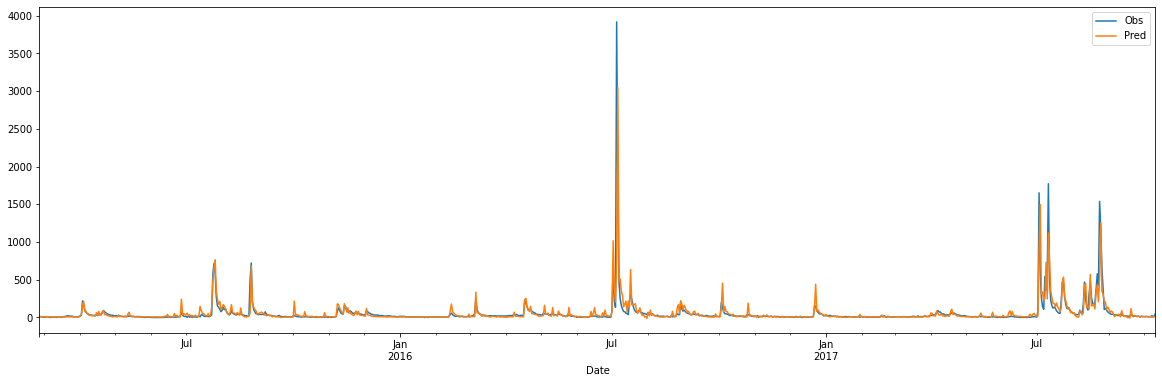

In [ ]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

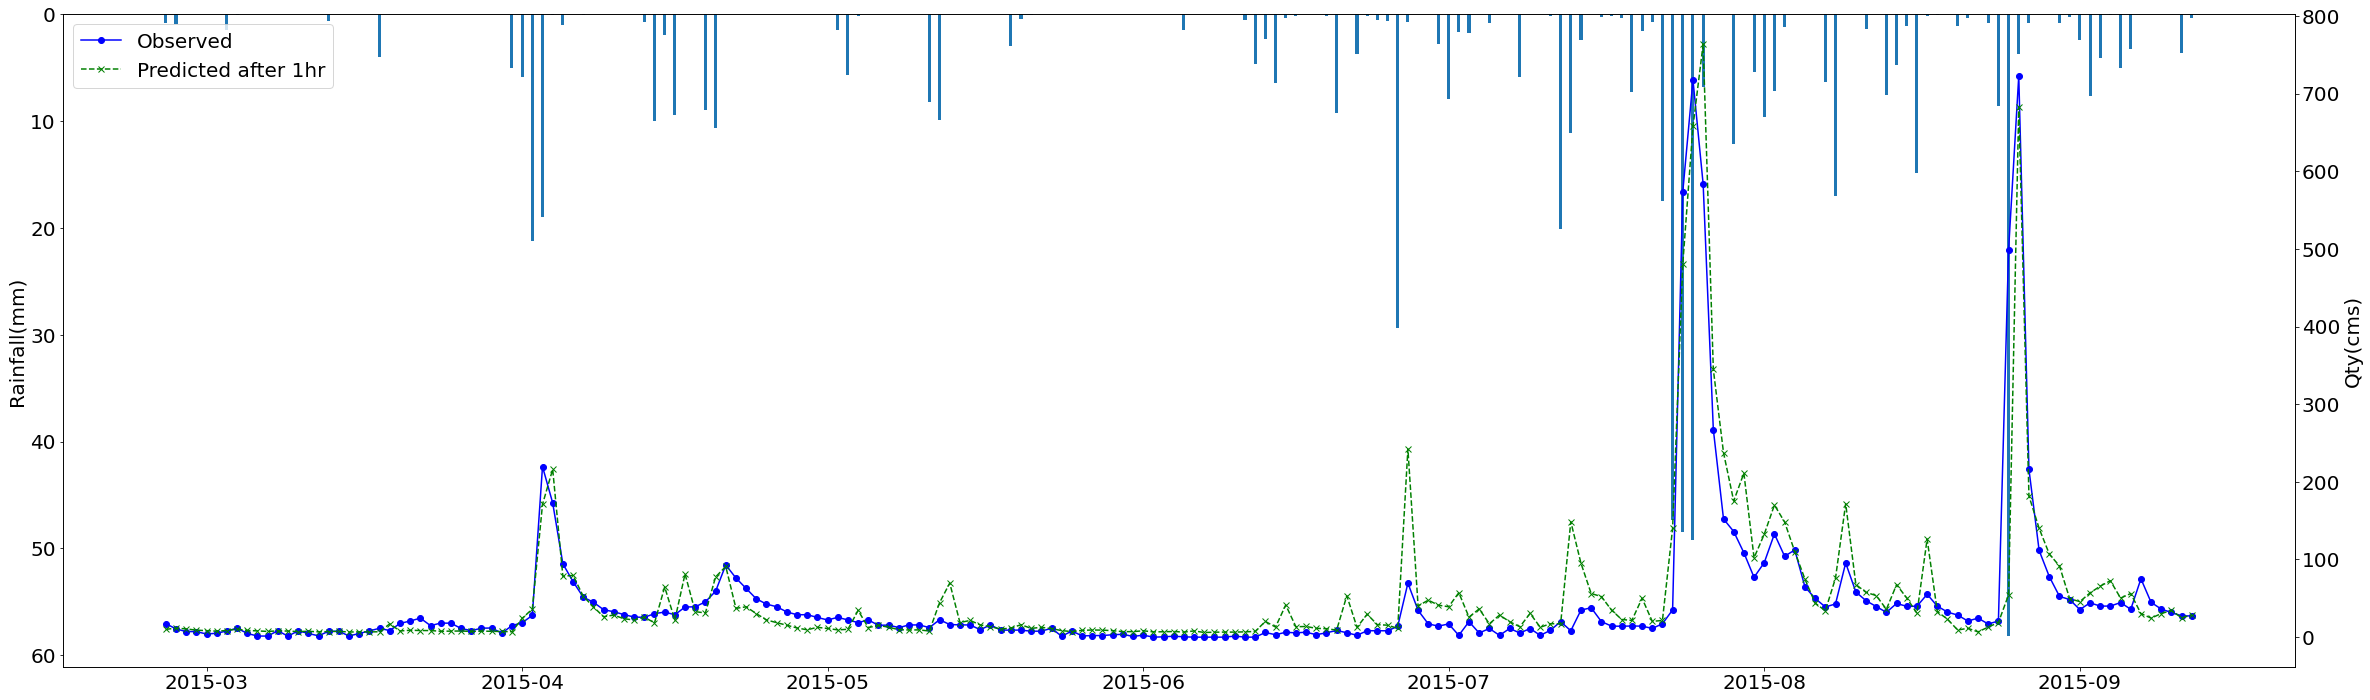

In [ ]:
df_predict = df_pred[0:200].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

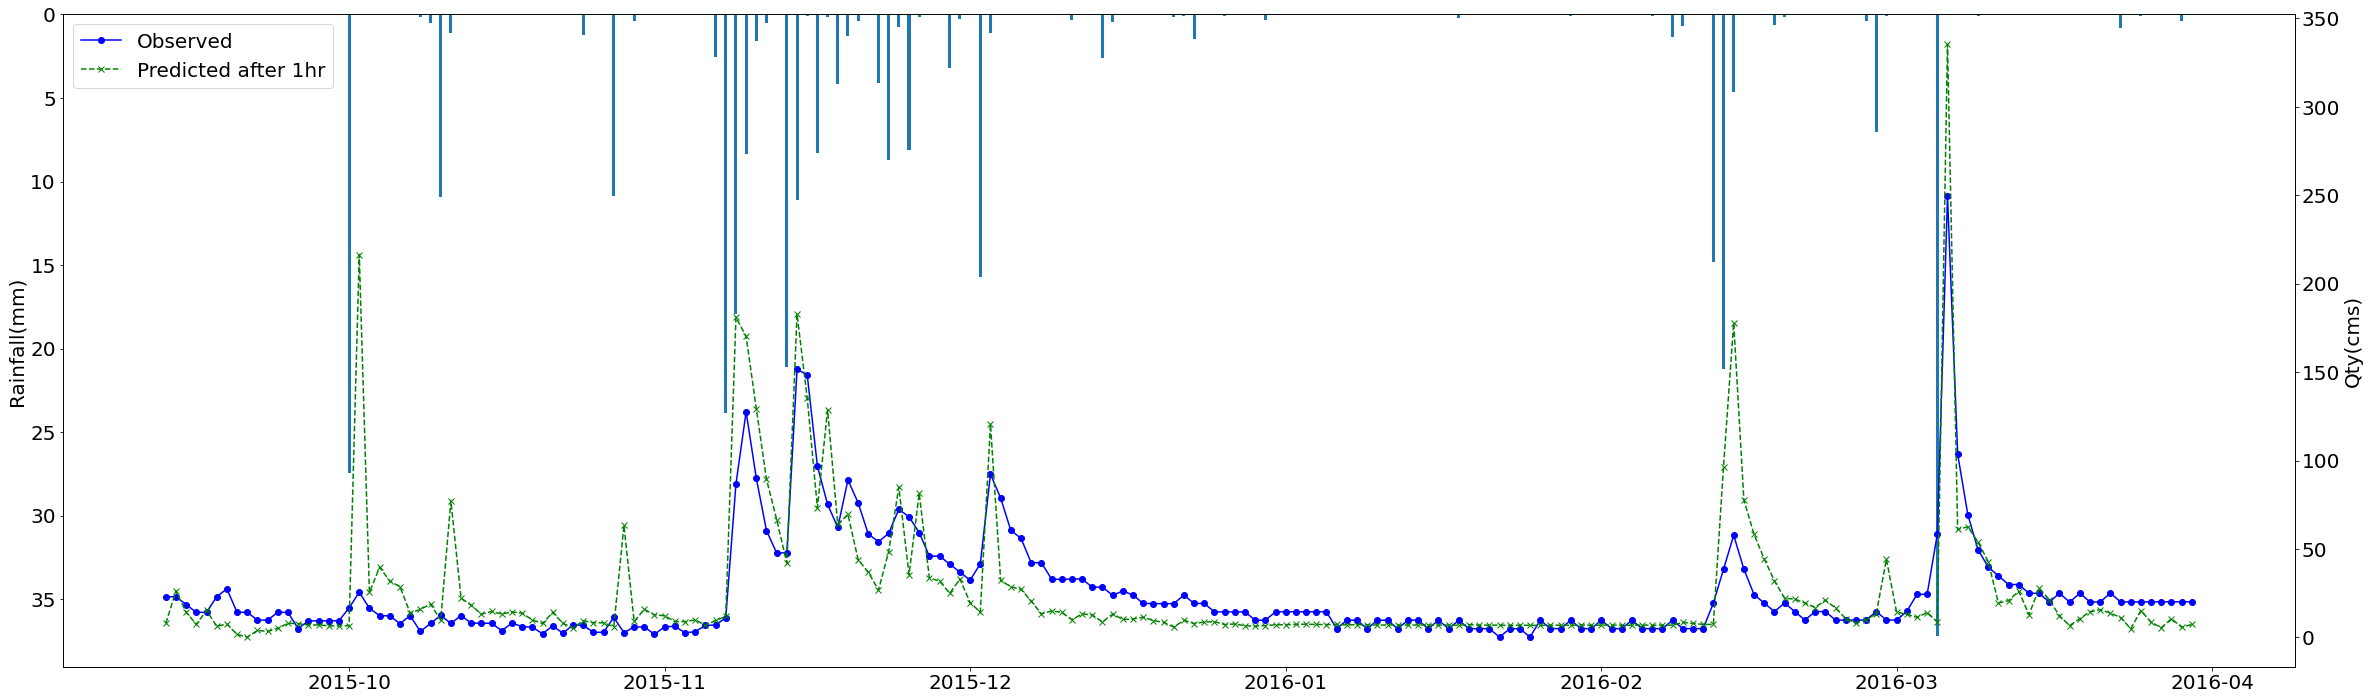

In [ ]:
df_predict = df_pred[200:400].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

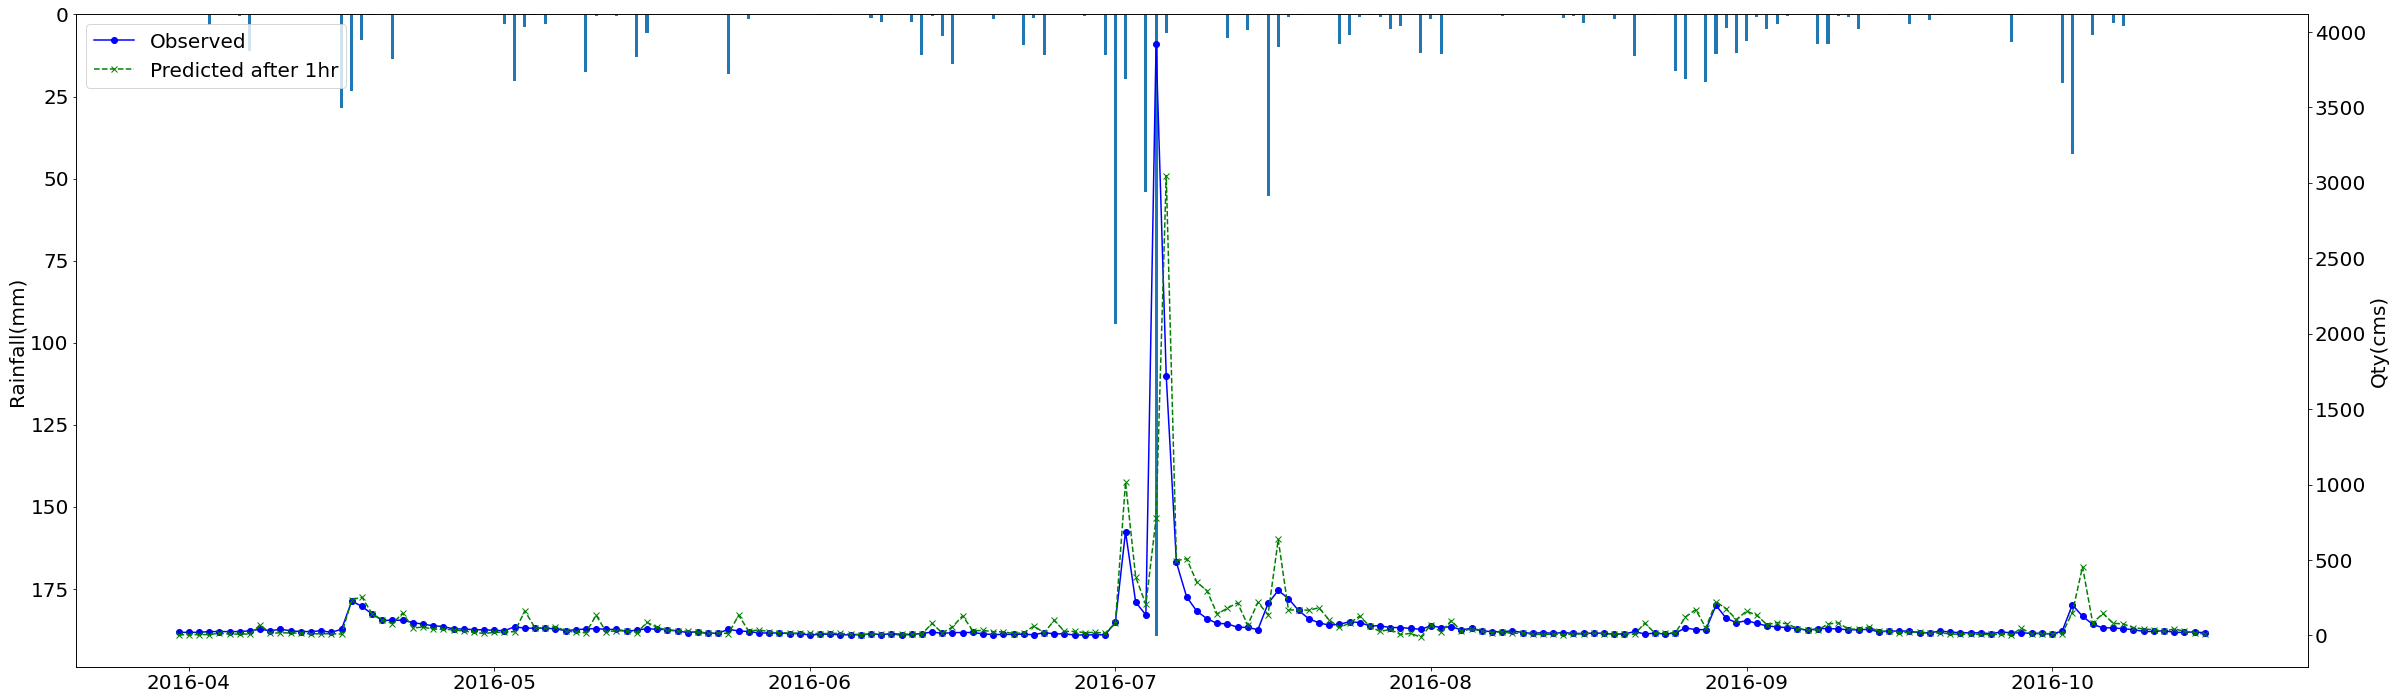

In [ ]:
df_predict = df_pred[400:600].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

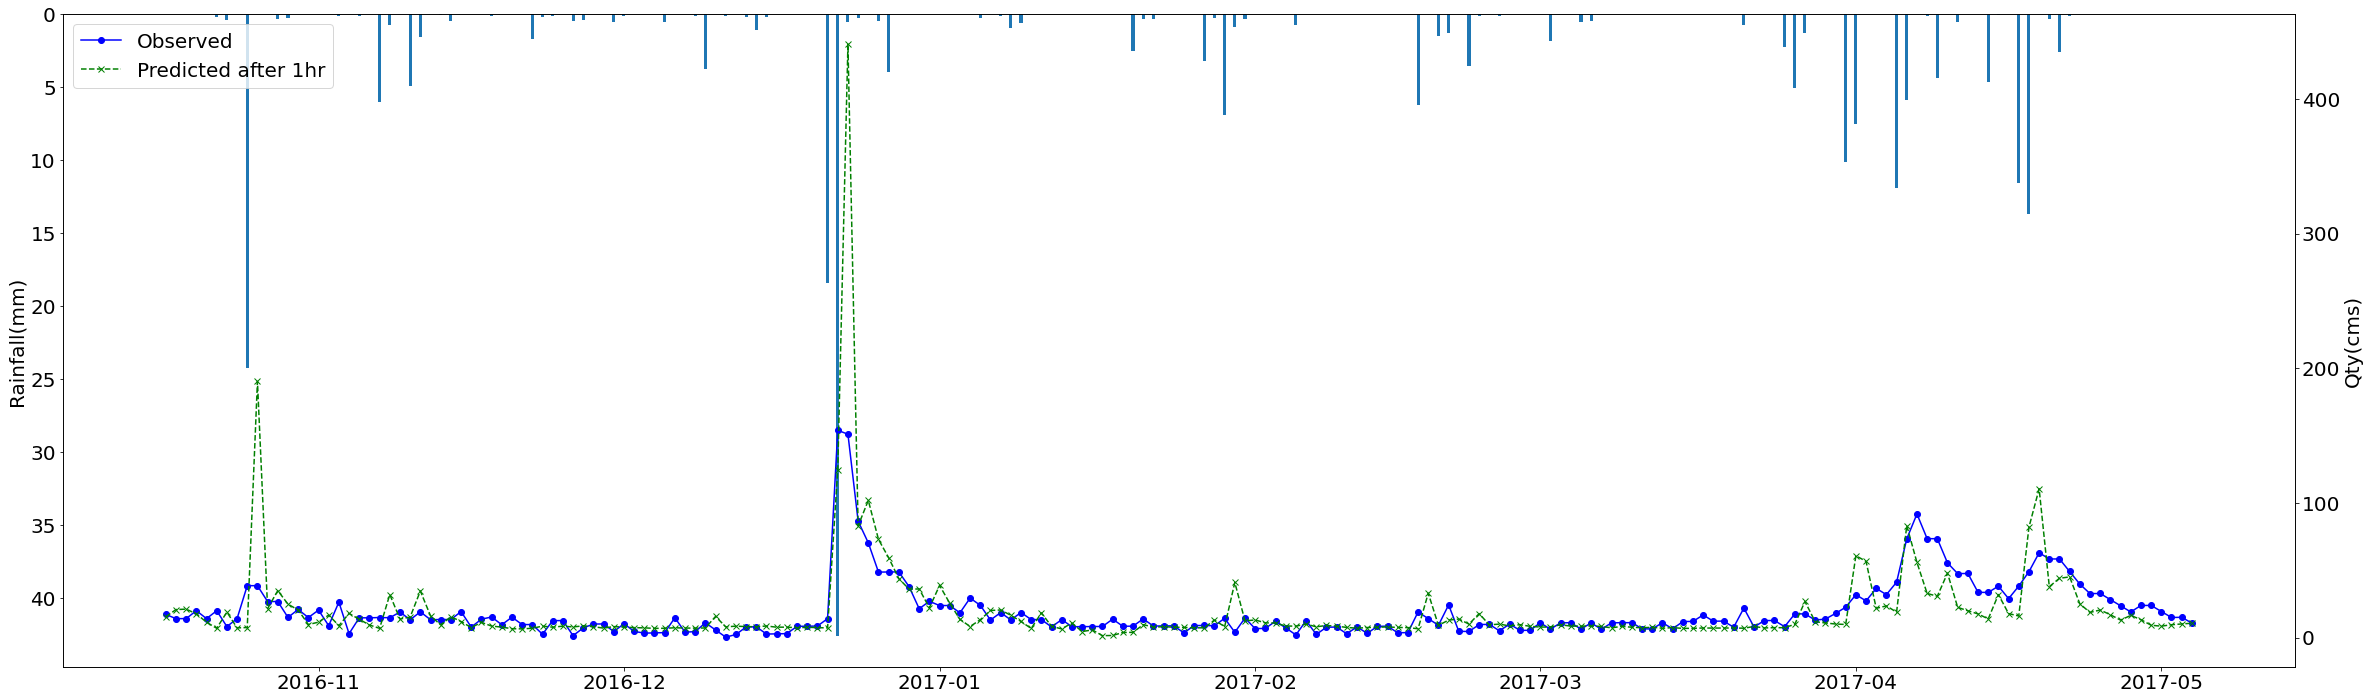

In [ ]:
df_predict = df_pred[600:800].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1hr'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)